In [1]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def run_cinema_ot(adata, condition_key, cell_type_key,exp_label,ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    print(adata_)
    sc.pp.pca(adata_)
    print(condition_key,ref_label,exp_label,cell_type_key)
    cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_, obs_label=condition_key, ref_label=ref_label,
                                                 expr_label=exp_label, mode='parametric', thres=0.5,
                                                 smoothness=1e-5, eps=1e-3, preweight_label=cell_type_key)
    de.write("./cinema_ot/"+dataset_name+"_ITE.h5ad")
    adata_.obsm['cf'] = cf.copy()
    adata_.obsm['cf'][adata_.obs[condition_key]==ref_label,:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs[condition_key]==exp_label,:])
    sc.pp.neighbors(adata_, use_rep='cf')

    sc.tl.umap(adata_, random_state=1)
    print("Effect modifier (called confounder in this paper) space:")
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    adata_.write("./cinema_ot/"+dataset_name+".h5ad")
    
    try:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")
    except:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


AnnData object with n_obs × n_vars = 16893 × 2000
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


condition control stimulated cell_type


Effect modifier (called confounder in this paper) space:


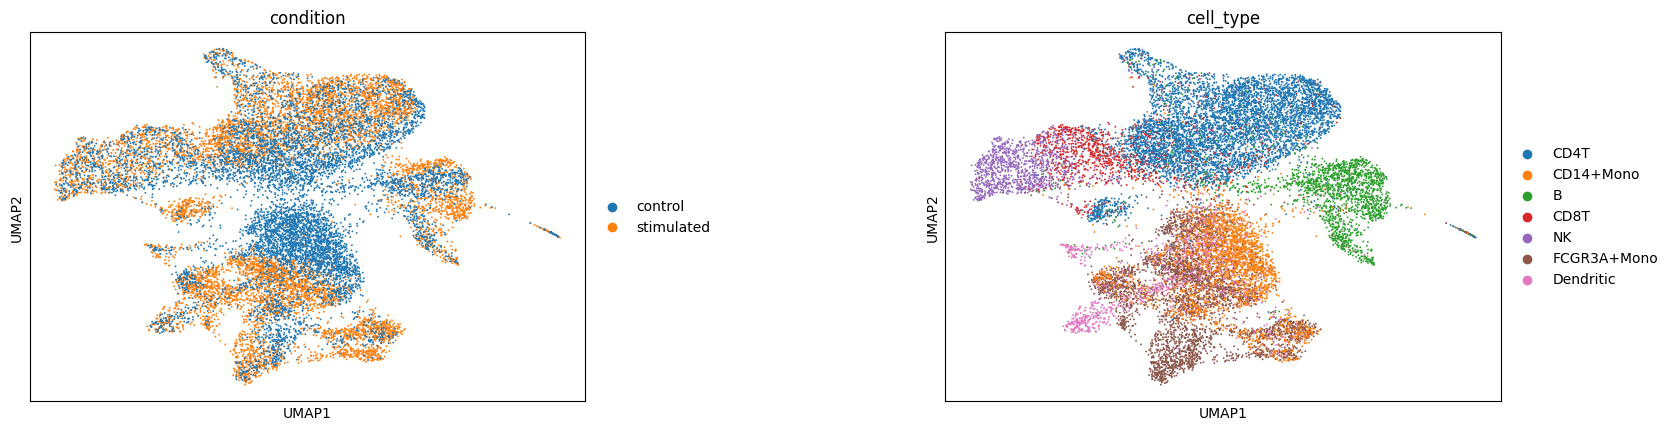

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /home/xx244/.conda/envs/benchmark/lib/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---


cLISI, bLISI, LISI_F1 0.9187782912793934 0.3165937967947126 0.47091805045097085


ASW---


asw_label 0.5141556691378355


asw_batch 0.7311486032445984


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


kbet_score 0.2674127488555875
graph_conn 0.9631783050627348


NMI, ARI ---
NMI 0.588890569536858
ARI 0.5544873571873327
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.514156  0.554487  0.588891  0.918778  0.316594   0.731149   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.267413            0.963178   0.991217   0.77985       0.271888   

     F1 LISI  
cf  0.470918  


In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_cinema_ot(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'dis

perturbation No stimulation IFNb cell_type0528


Effect modifier (called confounder in this paper) space:


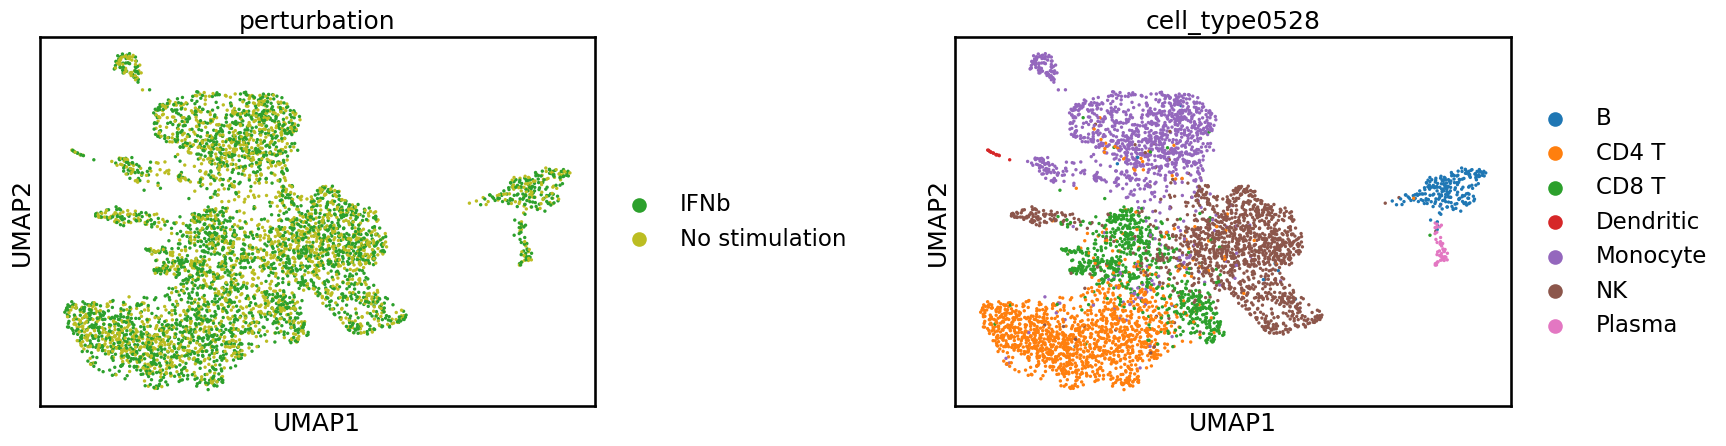

LISI---


cLISI, bLISI, LISI_F1 0.9502748205655763 0.5827511077406264 0.7224583669689966


ASW---


asw_label 0.533092338591814
asw_batch 0.8601618947491753


kBET---
0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.7088849824027588
graph_conn 0.9939705162913056


NMI, ARI ---
NMI 0.677206426476181
ARI 0.6853544622711988
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.533092  0.685354  0.677206  0.950275  0.582751   0.860162   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.708885            0.993971   0.998489  0.897951       0.662622   

     F1 LISI  
cf  0.722458  


In [4]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_cinema_ot(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 12255 × 2000
    obs: 'batch', 'leiden', 'cell_type1021', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


condition MOCK CSE cell_type1021


Effect modifier (called confounder in this paper) space:


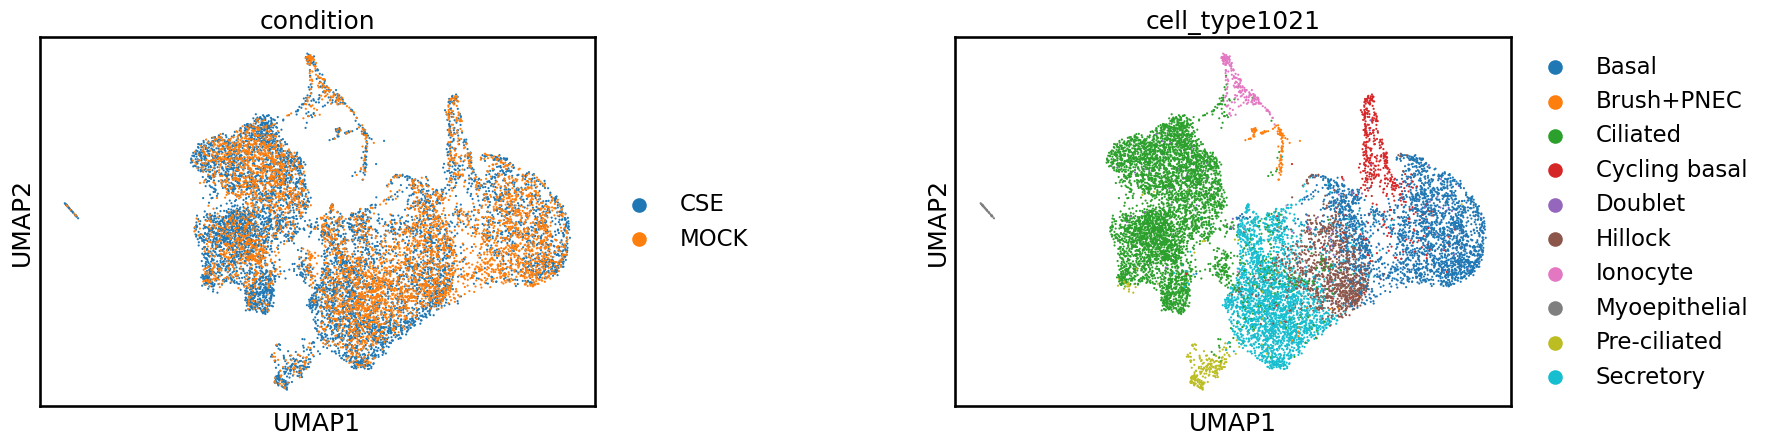

LISI---


cLISI, bLISI, LISI_F1 0.9764180367075428 0.45468713027758517 0.6204501602032719


ASW---


asw_label 0.5000222796370508


asw_batch 0.8315459656597867


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


kbet_score 0.5977637082639586
graph_conn 0.9459562294091695


NMI, ARI ---
NMI 0.6604747689110412
ARI 0.6470588661993157
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.500022  0.647059  0.660475  0.976418  0.454687   0.831546   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.597764            0.945956   0.860541  0.905508       0.378458   

    F1 LISI  
cf  0.62045  


In [5]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_cinema_ot(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HTO_classification_colors', 'MULTI_ID_colors', 'Phase_colors', 'gene_target_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 

perturbation Perturbed NT Phase


Effect modifier (called confounder in this paper) space:


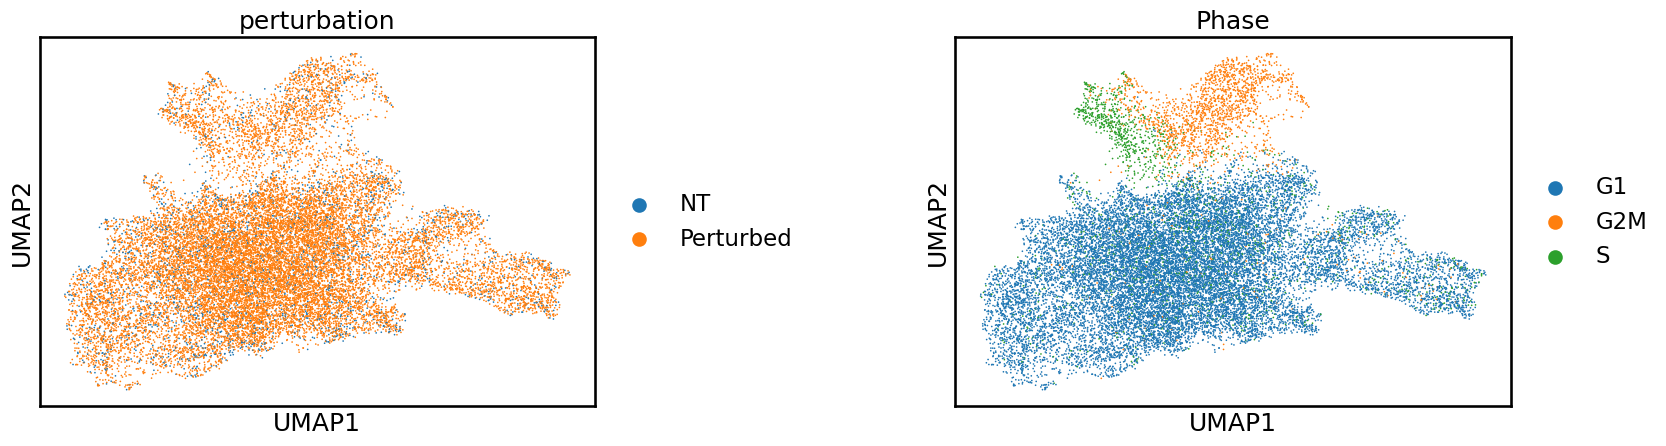

LISI---


cLISI, bLISI, LISI_F1 0.9272810895608511 0.02052525161471544 0.04016153269706483


ASW---


asw_label 0.5390674099326134


asw_batch 0.6464528658971308


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


kbet_score 0.8279356983451883
graph_conn 0.9194584123095018


NMI, ARI ---
NMI 0.42181076768240433
ARI 0.5505103402976648
positive and true positive rate---


    ASW_label      ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.539067  0.55051  0.421811  0.927281  0.020525   0.646453   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.827936            0.919458   0.995812  0.931449       0.805104   

     F1 LISI  
cf  0.040162  


In [6]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_cinema_ot(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

AnnData object with n_obs × n_vars = 49067 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 49067 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


perturb01 nan mutated CellType


Effect modifier (called confounder in this paper) space:


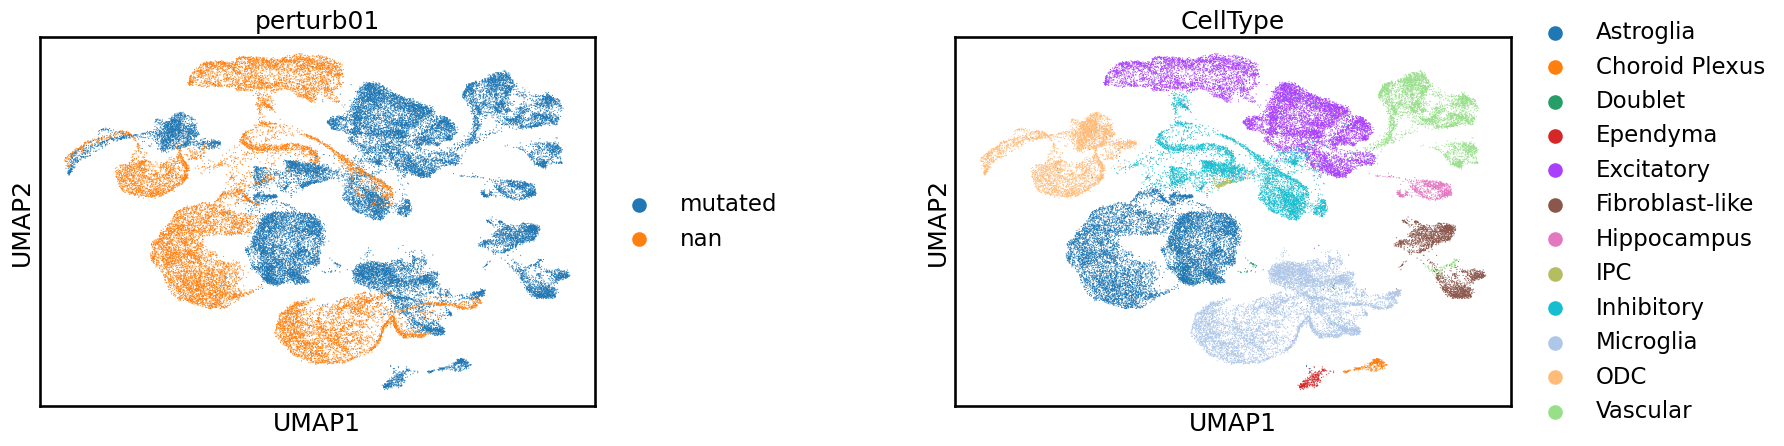

Cell cluster Hippocampus contains only one batch or has less than 10 cells. Skip.
Cell cluster IPC contains only one batch or has less than 10 cells. Skip.
Cell cluster Doublet contains only one batch or has less than 10 cells. Skip.
Cell cluster Fibroblast-like contains only one batch or has less than 10 cells. Skip.
Cell cluster Choroid Plexus contains only one batch or has less than 10 cells. Skip.
Cell cluster Ependyma contains only one batch or has less than 10 cells. Skip.
Cell cluster Vascular contains only one batch or has less than 10 cells. Skip.
LISI---


cLISI, bLISI, LISI_F1 0.9972482982206406 0.055012879989748915 0.10427354365253301


ASW---


asw_label 0.5558530576527119


asw_batch 0.6507182294814029


kBET---


7 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.41253678704895225
graph_conn 0.9868722405988124


NMI, ARI ---
NMI 0.8935637754773504
ARI 0.8633531541081799
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.555853  0.863353  0.893564  0.997248  0.055013   0.650718   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.412537            0.986872   0.537822  0.986182       0.332688   

     F1 LISI  
cf  0.104274  


In [7]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_cinema_ot(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")